In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import sklearn
import pickle

from utils_logistic import (
    GD, 
    RR_SVRG, 
    RR_VR,
    L_SVRG,
    SVRG,
    RR_SGD,
    SAGA_RR,
    SAGA
)
np.random.seed(1)
random.seed(1)

In [11]:
def load_data(path, normalize = True):
    A, y = datasets.load_svmlight_file(path)
    A = A.toarray()
    if (normalize == True):
        A = sklearn.preprocessing.normalize(A, norm="l2")
    n = A.shape[0]
    d = A.shape[1]
    return A, y, n, d

def compute_constants(A, y, n, d, lambd):
    eigvals, _ = np.linalg.eigh(np.transpose(A)@A)
    eig_max = max(eigvals)
    eig_min = min(eigvals)
    L = eig_max/4/n+lambd
    L_i_list = []
    for i in range(n):
        L_i_list.append(np.linalg.norm(A[i,:])**2/4+lambd)
    mu = lambd
    L_max = max(L_i_list)
    return L, mu, L_max, L_i_list

In [12]:
algo_func_pair = {
    "L-SVRG": L_SVRG,
    "RR": RR_SGD,
    "RR-SVRG": RR_SVRG,
    "SVRG": SVRG,
    "RR-SAGA": SAGA_RR,
    "SAGA": SAGA,
    "RR-VR.9": RR_VR,
    "RR-VR.5": RR_VR,
    "RR-VR.95": RR_VR,
    "RR-VR.8": RR_VR       
}

In [13]:
names = {
    "L-SVRG": "L_SVRG",
    "RR": "RR_SGD",
    "RR-SVRG": "Rand-Reshuffle",
    "SVRG": "SVRG",
    "RR-SAGA": "RR-SAGA",
    "SAGA": "SAGA",
    "RR-VR.9": "RR_VR",
    "RR-VR.5": "RR_VR",
    "RR-VR.95": "RR_VR",
    "RR-VR.8": "RR_VR"
}

In [14]:
algo_color_pair = {
    "L-SVRG": 'green',
    "RR": 'brown',
    "RR-SVRG": 'red',
    "SVRG": 'hotpink',
    "RR-SAGA": 'teal',
    "SAGA": 'purple',
    "RR-VR.9": 'navy',
    "RR-VR.5": 'limegreen',
    "RR-VR.95": 'grey',
    "RR-VR.8": 'pink'
}

In [15]:
def main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE):
    A, y, n, d = load_data(DATASET_NAME+".txt", normalize = NORMALIZE)
    if (STR_LAMBDA == '1_n'):
        lambd = 1/n
    elif (STR_LAMBDA == '10_n'):
        lambd = 10/n
    elif (STR_LAMBDA == '1_10n'):
        lambd = 1/10/n
    L, mu, L_max, L_i_list = compute_constants(A, y, n, d, lambd)
    print("n = {}, d = {}, L = {:.5f}, L_max = {:.5f}, mu = {:.5f}, kappa = {:.5f}".format(n, d, L, L_max, mu, L_max/mu))
    return A, y, n, d, lambd, L, mu, L_max, L_i_list

#### Experiment #2
Comparison of SAGA, SAGA-RR, RR-SVRG, L-SVRG, RR-VR0.5

Dataset: bodyfat, a1a

Algorithms: SAGA, SAGA_RR, RR_SVRG, L_SVRG, SVRG, RR-VR.5

In [16]:
def myMain(algo_name, A, y, lambd, n, d, stepsize, x_star, iter_num = 100):
    if (algo_name == "RR-VR.9"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.9, max_num_iter = iter_num)        
    if (algo_name == "RR-VR.8"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.8, max_num_iter = iter_num)
    if (algo_name == "RR-VR.5"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.5, max_num_iter = iter_num)    
    return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, max_num_iter = iter_num)

In [17]:
algos = ['SAGA', 'RR-SAGA', 'RR-SVRG', 'L-SVRG', 'RR-VR.5', 'SVRG']
DATASET_NAME = "abalone"
NORMALIZE = True
STR_LAMBDA = '1_n'

In [18]:
A, y, n, d, lambd, L, mu, L_max, L_i_list = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 4177, d = 8, L = 0.22473, L_max = 0.25024, mu = 0.00024, kappa = 1045.25000


In [8]:
x_star, _, grad_norms, _ = GD(A, y, lambd, n, d, 1/2/L, eps = 1e-12, max_iters_num=50)

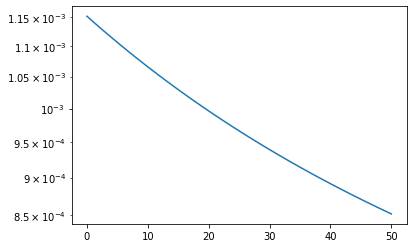

In [9]:
plt.semilogy(grad_norms)
plt.show()

In [10]:
stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [11]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
    results[algo]["grad_norms"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_grad[15])
            if (best_error > alg_grad[15]):
                    best_error = alg_grad[15].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)
        results[algo]["grad_norms"].append(best_grads)

SAGA
2.4895724803062264e-08
4.44983829396524 SAGA
1.0105400783944324e-08
2.22491914698262 SAGA
3.655906992535217e-09
1.4832794313217468 SAGA
5.595453079466775e-09
4.190125146548355e-07
RR-SAGA
1.4809340786155112e-10
4.44983829396524 RR-SAGA
6.893499957538828e-10
3.5577952478619482e-09
4.101676797689992e-08
1.1942645894454753e-06
RR-SVRG
7.380451852522577e-15
4.44983829396524 RR-SVRG
3.714866252249824e-17
2.22491914698262 RR-SVRG
6.821359367635239e-14
5.139724728228823e-10
4.1818766232730105e-07
L-SVRG
3.4803487469662536e-15
4.44983829396524 L-SVRG
2.958655780834672e-14
8.171697152493191e-13
6.686501117158809e-10
4.2285759247643286e-07
RR-VR.5
1.2718543241439237e-09
4.44983829396524 RR-VR.5
4.799893543301213e-11
2.22491914698262 RR-VR.5
2.025430152637493e-13
1.4832794313217468 RR-VR.5
5.139106258295244e-10
4.181561600143368e-07
SVRG
9.363180053014273e-17
4.44983829396524 SVRG
2.8859276737152143e-17
2.22491914698262 SVRG
6.87549396044781e-14
5.160848312671699e-10
4.188531654115875e-07


In [12]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


In [20]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        if (algo == 'RR-VR.5'):
            continue
        plt.semilogy(results[algo]['grad_comps'][0], error_best[algo], label = names[algo], marker='*', color=algo_color_pair[algo])
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 2)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()
    

In [21]:
def plot_results_grad(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        if (algo == 'RR-VR.5'):
            continue        
        plt.semilogy(results[algo]['grad_comps'][0], results[algo]['grad_norms'][0], label = names[algo], marker='*', color=algo_color_pair[algo])
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||\nabla f(x_k)||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 2)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()
    

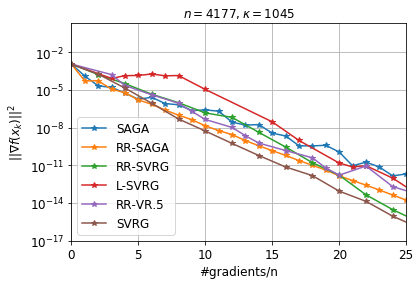

In [15]:
plot_results_grad(results, xlim = 25, ylim = 1e-17)

In [16]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "logistic",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'logistic_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

logistic_saga_svrg_rr_abalone_normalized_lambd_1_n


In [22]:
name = 'logistic_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)
in_pickle = pickle.load(open("plots/"+name+'.pickle', "rb" ))
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*in_pickle["results"][algo]['error'])]
    error_best[algo] = min(in_pickle["results"][algo]['error'], key=lambda x: x[-1])    

logistic_saga_svrg_rr_abalone_normalized_lambd_1_n
SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


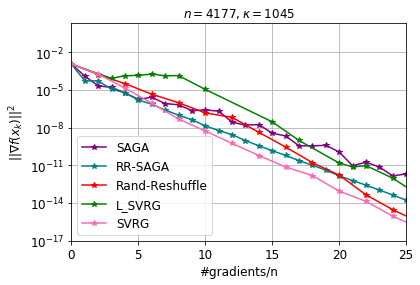

In [24]:
plot_results_grad(in_pickle['results'], xlim = 25, ylim = 1e-17, filename=name+'grad_neurips.pdf', save = True)

In [17]:
# plot_results_grad(results, xlim = 25, ylim = 1e-17, filename=name+'grad.pdf', save = True)

In [18]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### 2nd plot

In [25]:
algos = ['SAGA', 'RR-SAGA', 'RR-SVRG', 'L-SVRG', 'RR-VR.5', 'SVRG']
DATASET_NAME = "a5a"
NORMALIZE = True
STR_LAMBDA = '1_n'

stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [26]:
A, y, n, d, lambd, L, mu, L_max, L_i_list = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 6414, d = 122, L = 0.11353, L_max = 0.25016, mu = 0.00016, kappa = 1604.50000


In [47]:
x_star, _, grad_norms, _ = GD(A, y, lambd, n, d, 1/2/L, eps = 1e-12, max_iters_num=50)

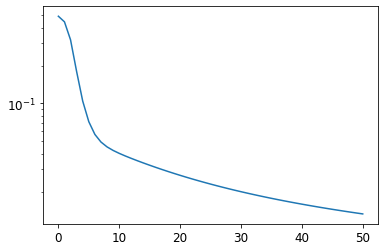

In [48]:
plt.semilogy(grad_norms)
plt.show()

In [49]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
    results[algo]["grad_norms"] = []    
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_grad[15])
            if (best_error > alg_grad[15]):
                    best_error = alg_grad[15].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)
        results[algo]["grad_norms"].append(best_grads)        

SAGA
0.11221157696318543
8.111869110653846 SAGA
0.0027287031105938703
4.055934555326923 SAGA
0.00022546151681211512
2.703956370217948 SAGA
4.3908137231252885e-05
1.622373822130769 SAGA
8.862495337349999e-06
0.8111869110653845 SAGA
RR-SAGA
0.020930906362643133
8.111869110653846 RR-SAGA
0.0003138324043061131
4.055934555326923 RR-SAGA
1.8111622066584323e-05
2.703956370217948 RR-SAGA
7.421776261805435e-08
1.622373822130769 RR-SAGA
2.502947701610613e-07
RR-SVRG
0.12581033847819467
8.111869110653846 RR-SVRG
1.1641293627352143e-05
4.055934555326923 RR-SVRG
6.596811715640741e-07
2.703956370217948 RR-SVRG
7.387414725738664e-10
1.622373822130769 RR-SVRG
5.88574707233407e-09
L-SVRG
0.018610405744393578
8.111869110653846 L-SVRG
4.654038558786365e-05
4.055934555326923 L-SVRG
1.4791021624251334e-06
2.703956370217948 L-SVRG
6.32570370390541e-08
1.622373822130769 L-SVRG
9.868506072468526e-09
0.8111869110653845 L-SVRG
RR-VR.5
0.030195101296626066
8.111869110653846 RR-VR.5
0.005754813789654448
4.0559345

In [52]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


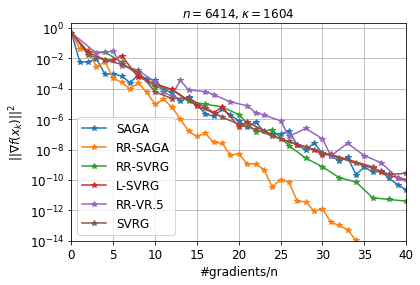

In [57]:
plot_results_grad(results, xlim=40, ylim=1e-14)

In [58]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "logistic",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'logistic_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

logistic_saga_svrg_rr_a5a_normalized_lambd_1_n


In [27]:
name = 'logistic_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)
in_pickle = pickle.load(open("plots/"+name+'.pickle', "rb" ))
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*in_pickle["results"][algo]['error'])]
    error_best[algo] = min(in_pickle["results"][algo]['error'], key=lambda x: x[-1])    

logistic_saga_svrg_rr_a5a_normalized_lambd_1_n
SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


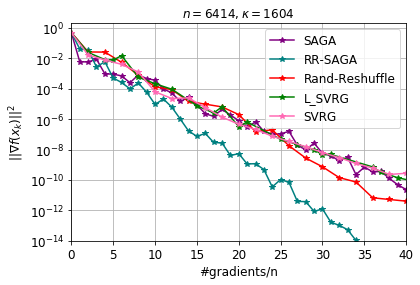

In [28]:
plot_results_grad(in_pickle['results'], xlim=40, ylim=1e-14, filename=name+'grad_neurips.pdf', save=True)  

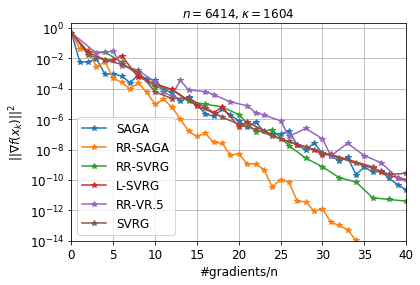

In [59]:
# plot_results_grad(results, xlim=40, ylim=1e-14, filename=name+'grad.pdf', save=True)  

In [60]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### 3rd plot

In [29]:
algos = ['SAGA', 'RR-SAGA', 'RR-SVRG', 'L-SVRG', 'RR-VR.5', 'SVRG']
DATASET_NAME = "a3a"
NORMALIZE = True
STR_LAMBDA = '1_n'

stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [30]:
A, y, n, d, lambd, L, mu, L_max, L_i_list = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 3185, d = 122, L = 0.11320, L_max = 0.25031, mu = 0.00031, kappa = 797.25000


In [69]:
x_star, _, grad_norms, _ = GD(A, y, lambd, n, d, 1/2/L, eps = 1e-12, max_iters_num=100)

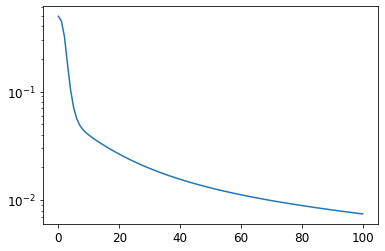

In [70]:
plt.semilogy(grad_norms)
plt.show()

In [71]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
    results[algo]["grad_norms"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_grad[15])
            if (best_error > alg_grad[15]):
                    best_error = alg_grad[15].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)
        results[algo]["grad_norms"].append(best_grads)

SAGA
0.11352238319331107
34.89788285172175 SAGA
0.06242451222933447
17.448941425860873 SAGA
0.13792621555035484
0.021965642811859514
6.979576570344349 SAGA
0.00030415010674184566
3.4897882851721747 SAGA
RR-SAGA
0.18385779204668606
34.89788285172175 RR-SAGA
0.05449521564588455
17.448941425860873 RR-SAGA
0.0372636634697264
11.632627617240582 RR-SAGA
0.011654359157195506
6.979576570344349 RR-SAGA
0.00020356997836093043
3.4897882851721747 RR-SAGA
RR-SVRG
0.1670112236916689
34.89788285172175 RR-SVRG
0.041376789644576716
17.448941425860873 RR-SVRG
0.02795330839563917
11.632627617240582 RR-SVRG
0.019098368836924146
6.979576570344349 RR-SVRG
2.4112631907683345e-06
3.4897882851721747 RR-SVRG
L-SVRG
0.05585469367373618
34.89788285172175 L-SVRG
0.062156667396828895
0.22161331716341434
0.030729142476141603
6.979576570344349 L-SVRG
0.00010827439482678306
3.4897882851721747 L-SVRG
RR-VR.5
0.15264262994751077
34.89788285172175 RR-VR.5
0.10749696582032807
17.448941425860873 RR-VR.5
0.07675464963160147

In [72]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


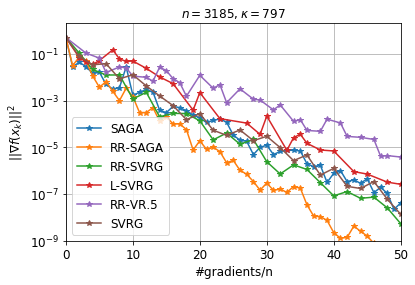

In [74]:
plot_results_grad(results, xlim=50, ylim=1e-9)

In [75]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "logistic",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'logistic_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

logistic_saga_svrg_rr_a3a_normalized_lambd_1_n


In [31]:
name = 'logistic_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)
in_pickle = pickle.load(open("plots/"+name+'.pickle', "rb" ))
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*in_pickle["results"][algo]['error'])]
    error_best[algo] = min(in_pickle["results"][algo]['error'], key=lambda x: x[-1])    

logistic_saga_svrg_rr_a3a_normalized_lambd_1_n
SAGA
RR-SAGA
RR-SVRG
L-SVRG
RR-VR.5
SVRG


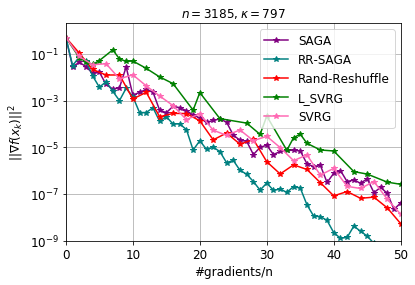

In [32]:
plot_results_grad(in_pickle['results'], xlim=50, ylim=1e-9, filename=name+'grad_neurips.pdf', save=True) 

In [76]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

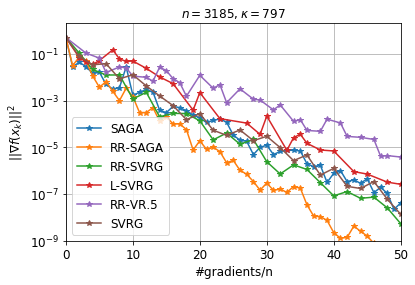

In [77]:
# plot_results_grad(results, xlim=50, ylim=1e-9, filename=name+'grad.pdf', save=True) 